# Introduction to TensorFlow

Welcome to this week's programming assignment! Up until now, you've always used Numpy to build neural networks, but this week you'll explore a deep learning framework that allows you to build neural networks more easily. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. TensorFlow 2.3 has made significant improvements over its predecessor, some of which you'll encounter and implement here!

By the end of this assignment, you'll be able to do the following in TensorFlow 2.3:

* Use `tf.Variable` to modify the state of a variable
* Explain the difference between a variable and a constant
* Apply TensorFlow decorators to speed up code
* Train a Neural Network on a TensorFlow dataset

Programming frameworks like TensorFlow not only cut down on time spent coding, but can also perform optimizations that speed up the code itself. 

## Table of Contents
- [1- Packages](#1)
    - [1.1 - Checking TensorFlow Version](#1-1)
- [2 - Basic Optimization with GradientTape](#2)
    - [2.1 - Linear Function](#2-1)
        - [Exercise 1 - linear_function](#ex-1)
    - [2.2 - Computing the Sigmoid](#2-2)
        - [Exercise 2 - sigmoid](#ex-2)
    - [2.3 - Using One Hot Encodings](#2-3)
        - [Exercise 3 - one_hot_matrix](#ex-3)
    - [2.4 - Initialize the Parameters](#2-4)
        - [Exercise 4 - initialize_parameters](#ex-4)
- [3 - Building Your First Neural Network in TensorFlow](#3)
    - [3.1 - Implement Forward Propagation](#3-1)
        - [Exercise 5 - forward_propagation](#ex-5)
    - [3.2 Compute the Cost](#3-2)
        - [Exercise 6 - compute_cost](#ex-6)
    - [3.3 - Train the Model](#3-3)
- [4 - Bibliography](#4)

<a name='1'></a>
## 1 - Packages

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<a name='1-1'></a>
### 1.1 - Checking TensorFlow Version 

You will be using v2.3 for this assignment, for maximum speed and efficiency.

In [2]:
tf.__version__

'2.6.0-dev20210419'

<a name='2'></a>
## 2 - Basic Optimization with GradientTape

The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with `GradientTape`. All that's left for you to do then is specify the cost function and optimizer you want to use! 

When writing a TensorFlow program, the main object to get used and transformed is the `tf.Tensor`. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

Below, you'll use `tf.Variable` to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the `dtype` arg in `tf.Variable` can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or `convert_to_tensor` will decide. It's generally best for you to specify directly, so nothing breaks!


Here you'll call the TensorFlow dataset created on a HDF5 file, which you can use in place of a Numpy array to store your datasets. You can think of this as a TensorFlow data generator! 

You will use the Hand sign data set, that is composed of images with shape 64x64x3.

In [3]:
train_dataset = h5py.File('datasets/train_signs.h5', "r")
test_dataset = h5py.File('datasets/test_signs.h5', "r")

In [7]:
train_dataset['train_set_x']

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">

In [14]:
# tf.data.Dataset.from_tensor_slices( list_or_numpy_array ) creates TensorFlow Datasets
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [15]:
type(x_train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

Since TensorFlow Datasets are generators, you can't access directly the contents unless you iterate over them in a for loop, or by explicitly creating a Python iterator using `iter` and consuming its
elements using `next`. Also, you can inspect the `shape` and `dtype` of each element using the `element_spec` attribute.

In [24]:
print(x_train.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [25]:
print(next(iter(x_train)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [20]:
for element in x_train:
    print(element)
    break

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the `map` method to apply the function passed as an argument to each of the elements.

In [34]:
def normalize(image):
    """
    Transform an image into a tensor of shape (64 * 64 * 3, 1)
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 256.0
    image = tf.reshape(image, [-1,1])
    return image

In [35]:
new_train = x_train.map(normalize)
new_test = x_test.map(normalize)

In [36]:
new_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [26]:
print(next(iter(new_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)


<a name='2-1'></a>
### 2.1 - Linear Function

Let's begin this programming exercise by computing the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

<a name='ex-1'></a>
### Exercise 1 - linear_function

Compute $WX + b$ where $W, X$, and $b$ are drawn from a random normal distribution. W is of shape (4, 3), X is (3,1) and b is (4,1). As an example, this is how to define a constant X with the shape (3,1):
```python
X = tf.constant(np.random.randn(3,1), name = "X")

```
Note that the difference between `tf.constant` and `tf.Variable` is that you can modify the state of a `tf.Variable` but cannot change the state of a `tf.constant`.

You might find the following functions helpful: 
- tf.matmul(..., ...) to do a matrix multiplication
- tf.add(..., ...) to do an addition
- np.random.randn(...) to initialize randomly

In [27]:
# GRADED FUNCTION: linear_function

def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """

    np.random.seed(1)
    
    """
    Note, to ensure that the "random" numbers generated match the expected results,
    please create the variables in the order given in the starting code below.
    (Do not re-arrange the order).
    """
    # (approx. 4 lines)
    # X = ...
    # W = ...
    # b = ...
    # Y = ...
    # YOUR CODE STARTS HERE
    X = tf.constant(np.random.randn(3,1))
    W = tf.constant(np.random.randn(4,3))
    b = tf.constant(np.random.randn(4,1))
    Y = tf.add(tf.matmul(W,X),b)
    
    # YOUR CODE ENDS HERE
    return Y

In [28]:
result = linear_function()
print(result)

assert type(result) == EagerTensor, "Use the TensorFlow API"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92mAll test passed")


tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
All test passed


**Expected Output**: 

```
result = 
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]
```

<a name='2-2'></a>
### 2.2 - Computing the Sigmoid 
Amazing! You just implemented a linear function. TensorFlow offers a variety of commonly used neural network functions like `tf.sigmoid` and `tf.softmax`.

For this exercise, compute the sigmoid of z. 

In this exercise, you will: Cast your tensor to type `float32` using `tf.cast`, then compute the sigmoid using `tf.keras.activations.sigmoid`. 

<a name='ex-2'></a>
### Exercise 2 - sigmoid

Implement the sigmoid function below. You should use the following: 

- `tf.cast("...", tf.float32)`
- `tf.keras.activations.sigmoid("...")`

In [37]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """
    # tf.keras.activations.sigmoid requires float16, float32, float64, complex64, or complex128.
    
    # (approx. 2 lines)
    # z = ...
    # result = ...
    # YOUR CODE STARTS HERE
    z = tf.cast(z,tf.float32)
    a = tf.keras.activations.sigmoid(z)
    # YOUR CODE ENDS HERE
    return a


In [38]:
result = sigmoid(-1)
print ("type: " + str(type(result)))
print ("dtype: " + str(result.dtype))
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

def sigmoid_test(target):
    result = target(0)
    assert(type(result) == EagerTensor)
    assert (result.dtype == tf.float32)
    assert sigmoid(0) == 0.5, "Error"
    assert sigmoid(-1) == 0.26894143, "Error"
    assert sigmoid(12) == 0.9999939, "Error"

    print("\033[92mAll test passed")

sigmoid_test(sigmoid)

type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.9999939, shape=(), dtype=float32)
All test passed


**Expected Output**: 
<table>
<tr> 
<td>
type
</td>
<td>
class 'tensorflow.python.framework.ops.EagerTensor'
</td>
</tr><tr> 
<td>
dtype
</td>
<td>
"dtype: 'float32'
</td>
</tr>
<tr> 
<td>
Sigmoid(-1)
</td>
<td>
0.2689414
</td>
</tr>
<tr> 
<td>
Sigmoid(0)
</td>
<td>
0.5
</td>
</tr>
<tr> 
<td>
Sigmoid(12)
</td>
<td>
0.999994
</td>
</tr> 

</table> 

<a name='2-3'></a>
### 2.3 - Using One Hot Encodings

Many times in deep learning you will have a $Y$ vector with numbers ranging from $0$ to $C-1$, where $C$ is the number of classes. If $C$ is for example 4, then you might have the following y vector which you will need to convert like this:


<img src="images/onehot.png" style="width:600px;height:150px;">

This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In TensorFlow, you can use one line of code: 

- [tf.one_hot(labels, depth, axis=0)](https://www.tensorflow.org/api_docs/python/tf/one_hot)

`axis=0` indicates the new axis is created at dimension 0

<a name='ex-3'></a>
### Exercise 3 - one_hot_matrix

Implement the function below to take one label and the total number of classes $C$, and return the one hot encoding in a column whise matrix. Use `tf.one_hot()` to do this, and `tf.reshape()` to reshape your one hot tensor! 

- `tf.reshape(tensor, shape)`

In [45]:
# GRADED FUNCTION: one_hot_matrix
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         one_hot -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    # (approx. 1 line)
    # one_hot = ...
    # YOUR CODE STARTS HERE
    one_hot = tf.one_hot(label,depth,axis=0)
    one_hot = tf.reshape(one_hot,[depth,1])
    
    # YOUR CODE ENDS HERE
    return one_hot

In [46]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print(result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert result.shape[1] == 1, f"Reshape to have only 1 column"
    assert np.allclose(result,  [[0.], [1.], [0.], [0.]] ), "Wrong output. Use tf.one_hot"
    result = target(3, depth)
    assert np.allclose(result, [[0.], [0.], [0.], [1.]] ), "Wrong output. Use tf.one_hot"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]], shape=(4, 1), dtype=float32)
All test passed


**Expected output**
```
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]], shape=(4, 1), dtype=float32)
```

In [47]:
new_y_test = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

In [53]:
print(next(iter(new_y_test)))

tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


<a name='2-4'></a>
### 2.4 - Initialize the Parameters 

Now you'll initialize a vector of numbers between zero and one. The function you'll be calling is `tf.keras.initializers.GlorotNormal`, which draws samples from a truncated normal distribution centered on 0, with `stddev = sqrt(2 / (fan_in + fan_out))`, where `fan_in` is the number of input units and `fan_out` is the number of output units, both in the weight tensor. 

To initialize with zeros or ones you could use `tf.zeros()` or `tf.ones()` instead. 

<a name='ex-4'></a>
### Exercise 4 - initialize_parameters

Implement the function below to take in a shape and to return an array of numbers between -1 and 1. 

 - `tf.keras.initializers.GlorotNormal(seed=1)`
 - `tf.Variable(initializer(shape=())`

In [62]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)   
    #(approx. 6 lines of code)
    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [63]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


**Expected output**
```
W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
```

In [64]:
parameters = initialize_parameters()

<a name='3'></a>
## 3 - Building Your First Neural Network in TensorFlow

In this part of the assignment you will build a neural network using TensorFlow. Remember that there are two parts to implementing a TensorFlow model:

- Implement forward propagation
- Retrieve the gradients and train the model

Let's get into it!

<a name='3-1'></a>
### 3.1 - Implement Forward Propagation 

One of TensorFlow's great strengths lies in the fact that you only need to implement the forward propagation function. 

Here, you'll use a TensorFlow decorator, `@tf.function`, which builds a  computational graph to execute the function. `@tf.function` is polymorphic, which comes in very handy, as it can support arguments with different data types or shapes, and be used with other languages, such as Python. This means that you can use data dependent control flow statements.

When you use `@tf.function` to implement forward propagation, the computational graph is activated, which keeps track of the operations. This is so you can calculate your gradients with backpropagation.

<a name='ex-5'></a>
### Exercise 5 - forward_propagation

Implement the `forward_propagation` function.

**Note** Use only the TF API. 

- tf.math.add
- tf.linalg.matmul
- tf.keras.activations.relu


In [65]:
# GRADED FUNCTION: forward_propagation

@tf.function
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #(approx. 5 lines)                   # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)    # Z1 = np.dot(W1, X) + b1
    A1 = tf.keras.activations.relu(Z1) # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)   # Z2 = np.dot(W2, A1) + b2
    A2 = tf.keras.activations.relu(Z2) # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)   # Z3 = np.dot(W3, A2) + b3
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    
    return Z3

In [66]:
def forward_propagation_test(target, examples):
    for batch in examples:
        forward_pass = target(batch, parameters)
        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 1), "Last layer must use W3 and b3"
        assert np.any(forward_pass < 0), "Don't use a ReLu layer at end of your network"
        assert np.allclose(forward_pass, 
                           [[-0.13082162],
                           [ 0.21228778],
                           [ 0.7050022 ],
                           [-1.1224034 ],
                           [-0.20386729],
                           [ 0.9526217 ]]), "Output does not match"
        print(forward_pass)
        break
    

    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_train)

tf.Tensor(
[[-0.13082105]
 [ 0.21228725]
 [ 0.7050022 ]
 [-1.1224037 ]
 [-0.20386747]
 [ 0.95262206]], shape=(6, 1), dtype=float32)
All test passed


**Expected output**
```
tf.Tensor(
[[-0.13082162]
 [ 0.21228778]
 [ 0.7050022 ]
 [-1.1224034 ]
 [-0.20386732]
 [ 0.9526217 ]], shape=(6, 1), dtype=float32)
```

<a name='3-2'></a>
### 3.2 Compute the Cost

Here again, the delightful `@tf.function` decorator steps in and saves you time. All you need to do is specify how to compute the cost, and you can do so in one simple step by using:

`tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = ..., y_pred = ..., from_logits=True))`

<a name='ex-6'></a>
### Exercise 6 -  compute_cost

Implement the cost function below. 
- It's important to note that the "`y_pred`" and "`y_true`" inputs of [tf.keras.losses.binary_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy) are expected to be of shape (number of examples, num_classes). Since both the transpose and the original tensors have the same values, just in different order, the result of calculating the binary_crossentropy should be the same if you transpose or not the logits and labels. Just for reference here is how the Binary Cross entropy is calculated in TensorFlow:

``mean_reduce(max(logits, 0) - logits * labels + log(1 + exp(-abs(logits))), axis=-1)``

- `tf.reduce_mean` basically does the summation over the examples.

In [67]:
# GRADED FUNCTION: compute_cost 

@tf.function
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    #(1 line of code)
    # cost = ...
    # YOUR CODE STARTS HERE
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(labels,logits,from_logits=True))
    
    # YOUR CODE ENDS HERE
    return cost

In [68]:
def compute_cost_test(target):
    labels = np.array([[0., 1.], [0., 0.], [1., 0.]])
    logits = np.array([[0.6, 0.4], [0.4, 0.6], [0.4, 0.6]])
    result = compute_cost(logits, labels)
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.7752516 +  0.9752516 + 0.7752516) / 3.0) < 1e-7), "Test does not match. Did you get the mean of your cost functions?"

    print("\033[92mAll test passed")

compute_cost_test(compute_cost)

tf.Tensor(0.8419182681095858, shape=(), dtype=float64)
All test passed


**Expected output**
```
tf.Tensor(0.87525165, shape=(), dtype=float32)
```

<a name='3-3'></a>
### 3.3 - Train the Model

Let's talk optimizers. You'll specify the type of optimizer in one line, in this case `tf.keras.optimizers.Adam` (though you can use others such as SGD), and then call it within the training loop. 

Notice the `tape.gradient` function: this allows you to retrieve the operations recorded for automatic differentiation inside the `GradientTape` block. Then, calling the optimizer method `apply_gradients`, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do. ;) 


Here you should take note of an important extra step that's been added to the batch training process: 

- `tf.Data.dataset = dataset.prefetch(8)` 

What this does is prevent a memory bottleneck that can occur when reading from disk. `prefetch()` sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory. 

In [69]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    
    # Initialize your parameters
    #(1 line)
    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    optimizer = tf.keras.optimizers.SGD(learning_rate)

    X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):

        epoch_cost = 0.
        
        for (minibatch_X, minibatch_Y) in zip(X_train, Y_train):
            # Select a minibatch
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(minibatch_X, parameters)
                # 2. loss
                minibatch_cost = compute_cost(Z3, minibatch_Y)
                
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            epoch_cost += minibatch_cost / minibatch_size

        # Print the cost every epoch
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if print_cost == True and epoch % 5 == 0:
            costs.append(epoch_cost)

    # Plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save the parameters in a variable
    print ("Parameters have been trained!")

    return parameters

Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
Cost after epoch 50: 0.570628
Cost after epoch 60: 0.560898
Cost after epoch 70: 0.550808
Cost after epoch 80: 0.540494
Cost after epoch 90: 0.488080
Cost after epoch 100: 0.478259
Cost after epoch 110: 0.472858
Cost after epoch 120: 0.468990
Cost after epoch 130: 0.466013
Cost after epoch 140: 0.463659
Cost after epoch 150: 0.461677
Cost after epoch 160: 0.459950
Cost after epoch 170: 0.458390
Cost after epoch 180: 0.456969
Cost after epoch 190: 0.455646


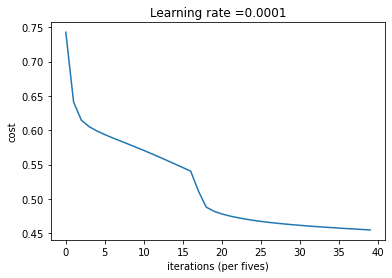

Parameters have been trained!


{'W1': <tf.Variable 'Variable:0' shape=(25, 12288) dtype=float32, numpy=
 array([[ 0.00159519, -0.00737921,  0.00893288, ..., -0.01227796,
          0.01642204,  0.00506491],
        [ 0.02264025,  0.0067227 ,  0.00795862, ...,  0.00284724,
          0.01910819,  0.00122853],
        [-0.00173595, -0.00872464, -0.01410454, ..., -0.00733839,
          0.02050855, -0.02683005],
        ...,
        [-0.00126929,  0.01729332,  0.02082342, ...,  0.01709594,
          0.00429358, -0.00733263],
        [ 0.00268254,  0.00410491,  0.009367  , ...,  0.01222265,
         -0.02717625,  0.01498343],
        [-0.00145541,  0.02459595,  0.00339064, ..., -0.02478788,
          0.02716016, -0.00306428]], dtype=float32)>,
 'b1': <tf.Variable 'Variable:0' shape=(25, 1) dtype=float32, numpy=
 array([[ 0.03964256],
        [-0.15545043],
        [ 0.19885878],
        [-0.24874453],
        [-0.28676695],
        [-0.126046  ],
        [-0.01213089],
        [ 0.14784032],
        [-0.00413168],
        

In [70]:
model(new_train, new_y_train, new_test, new_y_test, num_epochs=200)

**Expected output**

```
Cost after epoch 0: 0.742591
Cost after epoch 10: 0.614557
Cost after epoch 20: 0.598900
Cost after epoch 30: 0.588907
Cost after epoch 40: 0.579898
...
```

**Congratulations**! You've made it to the end of this assignment, and to the end of this week's material. Amazing work building a neural network in TensorFlow 2.3! 

Here's a quick recap of all you just achieved:

- Used `tf.Variable` to modify your variables
- Applied TensorFlow decorators and observed how they sped up your code
- Trained a Neural Network on a TensorFlow dataset
- Applied batch normalization for a more robust network

You are now able to harness the power of TensorFlow's computational graph to create cool things, faster. Nice! 

<a name='4'></a>
## 4 - Bibliography 

In this assignment, you were introducted to `tf.GradientTape`, which records operations for differentation. Here are a couple of resources for diving deeper into what it does and why: 

Introduction to Gradients and Automatic Differentiation: 
https://www.tensorflow.org/guide/autodiff 

GradientTape documentation:
https://www.tensorflow.org/api_docs/python/tf/GradientTape